# Chloroplast Movement vs. Lux - Ethan Knight (with Peter Alfonsi)

### Claim:
We conclude that there is a correlation between light intensity and cytoplasmic streaming.
### Evidence and Reasoning:
In this experiement, we wanted to see if changing the amount of light a chloroplast was receiving would change the amount of total movement within each chloroplast. We took 6 total trials on 4 different light levels, keeping aperature and length of time the same across all trials. For each trial, we switched the monitoring frame - this explains the somewhat wide variety of points we got on each trial. We adjusted the microscope light knob to the same level for each trial. 

We wanted a reliable, quantitative, and efficient way to track chloroplasts. The Lucas-Kanade algorithm that computed optical flow (i.e. how a point moves through space) would be ideal for this application. Using the Lucas-Kanade motion tracking algorithm implemented in OpenCV, we monitored the movement of the chloroplasts inside each cell and took a linear regression. What we found was a positive correlation between lux (lumens/meter^2) and chloroplast movement. You can see the graph below (Figure 1).

Below is the code used to generate the movement and the graph. The Lux was calculated using a light detector and taking a exponential regression. In order to achieve sensible tracking results, we adjusted the quality parameter of the algorithm so that on low light levels so it didn't pick up noise (Figure 2). You can see the results near the bottom of the document.

### Data:

In [15]:
display(df)

,Light Level (Lux),Movement (Pixels/Frame)
0,1050.000,325.498069
1,1050.000,36.745256
2,1050.000,150.296992
3,1050.000,13.942890
4,1050.000,7.351162
5,1050.000,76.381459
6,3646.044,781.489006
7,3646.044,824.903031
8,3646.044,996.398197
9,3646.044,150.668572


              Figure 1

### Analysis:

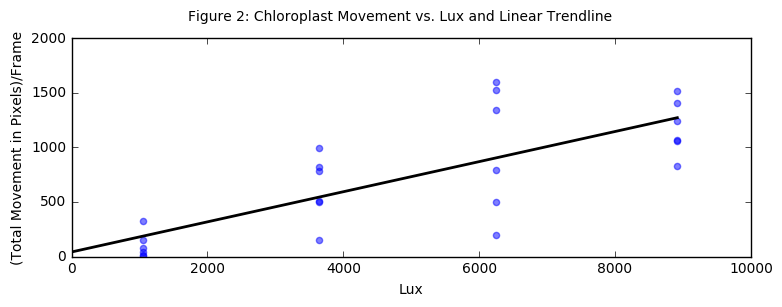

In [17]:
fig

### Works Cited:
1. <br>
    Cytoplasmic Streaming. (2016). In Encyclopædia Britannica. 
    <br>Retrieved from https://www.britannica.com/science/cytoplasmic-streaming

2. <br>
    Solem, J. E. (2012). Programming computer vision with Python. Retrieved September 28, 2016, from 
    http://programmingcomputervision.com/downloads/ProgrammingComputerVision_CCdraft.pdf


### Appendix A: Example of motion tracking

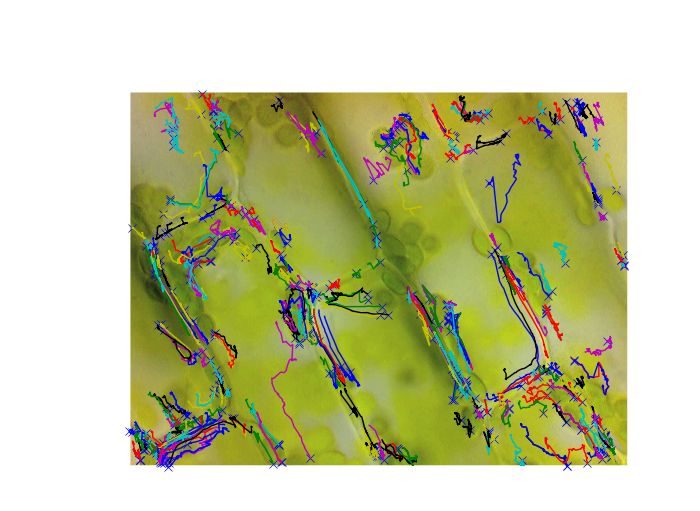

830.1854122416787

In [20]:
totalMovement("100light3.mov", cellsInPicture=7, lightLevel = 0.05, showFigures=True, printStuff=False)

### Appendix B: Code

In [1]:
from numpy import *
import cv2
from pylab import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# LKTracker modified from 
# http://programmingcomputervision.com/downloads/
# ProgrammingComputerVision_CCdraft.pdf
lk_params = dict(winSize=(15,15),maxLevel=2,
                criteria=(cv2.TERM_CRITERIA_EPS | \
                          cv2.TERM_CRITERIA_COUNT,10,0.03)) 

subpix_params = dict(zeroZone=(-1,-1),winSize=(10,10),
                     criteria = (cv2.TERM_CRITERIA_COUNT | \
                                 cv2.TERM_CRITERIA_EPS,\
                                 20,0.03))

feature_params = dict(maxCorners=300,qualityLevel=0.1,\
                      minDistance=5)


class LKTracker(object):

    def __init__(self,images):
        self.images = images
        self.features = []
        self.tracks = []
        self.current_frame = 0

    def step(self,framenbr=None):
        if framenbr is None:
            self.current_frame = (self.current_frame + 1) % len(self.images)
        else:
            self.current_frame = framenbr % len(self.images)

    def detect_points(self):
        self.image = self.images[self.current_frame]
        self.gray = cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY)
        features = cv2.goodFeaturesToTrack(self.gray, **feature_params)
        cv2.cornerSubPix(self.gray,features, **subpix_params)
        self.features = features
        self.tracks = [[p] for p in features.reshape((-1,2))]
        self.prev_gray = self.gray

    def track_points(self):
        if self.features != []:
            self.step()
            self.image = self.images[self.current_frame]
            self.gray = cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY)
            tmp = float32(self.features).reshape(-1, 1, 2)            
            features,status,track_error = cv2.calcOpticalFlowPyrLK(\
                       self.prev_gray,self.gray,tmp,None,**lk_params)
            self.features = [p for (st,p) in zip(status,features) if st]  
            features = array(features).reshape((-1,2))
            for i,f in enumerate(features):
                self.tracks[i].append(f)
            ndx = [i for (i,st) in enumerate(status) if not st]
            ndx.reverse() #remove from back
            for i in ndx:
                self.tracks.pop(i)
            
            self.prev_gray = self.gray
            
    def track(self):
        for i in range(len(self.images)):
            if self.features == []:
                self.detect_points()
            else:
                self.track_points()
            
            # create a copy in RGB
            f = array(self.features).reshape(-1,2)
            im = cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)
            yield im,f

    def draw(self):
        for point in self.features:
            cv2.circle(self.image,(int(point[0][0]),int( \
                            point[0][1])),3,(0,255,0),-1)
        
        cv2.imshow('LKtrack',self.image)
        cv2.waitKey()

In [19]:
%matplotlib inline
def rejectOutliers(data):
    #from https://stackoverflow.com/questions/11686720/
    # is-there-a-numpy-builtin-to-reject-outliers-from-a-list
    m = 3
    u = np.mean(data)
    s = np.std(data)
    filtered = [e for e in data if (u - 2 * s < e < u + 2 * s)]
    return filtered

def totalMovement(filename, cellsInPicture=1, lightLevel=0.1, \
                  removeOutliers=False, printStuff=False, showFigures=False):
    global feature_params
    #cells in picture = 1 -> 20
    #cells in pic
    feature_params["minDistance"] = 7
    feature_params["maxCorners"] = 600
    feature_params["qualityLevel"] = lightLevel
    if printStuff:
        print(feature_params)
    vidcap = cv2.VideoCapture(filename)
    frames = []
    count = 0;
    success=True
    while success:
        success,image = vidcap.read(1)
        frames.append(image)
        if cv2.waitKey(10) == 27:    # exit if Escape is hit
            break
        count += 1
    if printStuff:
        print("Finished processing frames")
        print(str(len(frames))+" frames")
    missedFrames = 0
    frames = frames[:-1]
    if printStuff:
        print("Finished uncorrupting frames")
        print(str(len(frames))+" frames")
    lkt = LKTracker(frames)
    
    for im, ft in lkt.track():
        pass
    
    totalList=[]
    for t in lkt.tracks:
        a=[p[0] for p in t]
        b=[p[1] for p in t]
        totalList.append(sqrt((a[0]-b[0])**2+(a[1]-b[1])**2))
    
    if showFigures:
        figure(figsize=(8,6))
        imshow(im)
        for p in ft:
            plot(p[0],p[1],'bx')
        for t in lkt.tracks:
            plot([p[0] for p in t],[p[1] for p in t])
        axis('off')
        show()
        plt.figure(figsize=(3, 1.5))
        #plt.plot(sort(totalList))
        plt.show()
    
    if removeOutliers:
        totalList = rejectOutliers(totalList)
    return sum(totalList)/(count+missedFrames) #movement per frame

In [ ]:
import statsmodels.api as sm
from tqdm import tqdm

#some graphing code from 
#https://drive.google.com/drive/u/0/folders/0ByIrJAE4KMTtaGhRcXkxNHhmY2M

params = [0.35, 0.25, 0.2, 0.05]
x,y=[],[]

for ind, lightLevel in tqdm(enumerate([0,33,66,100])):
    for trial in [1,2,3,4,5,6]:
        lux = float("78.668")*lightLevel+1050
        x.append(lux)
        movieName = str(lightLevel)+"light"+str(trial)+".mov"
        #print(movieName)
        y.append(totalMovement(movieName, cellsInPicture=7, \
                               lightLevel=params[ind]))


fig, ax = plt.subplots(figsize=(8, 3))
ax.scatter(x, y, alpha=0.5, color="blue")
fig.suptitle('Chloroplast Movement vs. Lux')
fig.tight_layout(pad=2)

x = sm.add_constant(x)
model = sm.OLS(y,x)
fitted = model.fit()
x_pred = np.linspace(x.min(), x.max(), 50)
x_pred2 = sm.add_constant(x_pred)
y_pred = fitted.predict(x_pred2)
ax.set_xlabel("Lux")
ax.set_ylabel("(Total Movement in Pixels)/Frame")

ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)

fig.savefig('chloroplastGraph.png', dpi=400)

In [16]:
from IPython.display import display, HTML
import pandas as pd
ax.plot(x_pred, y_pred, '-',
       color='black', linewidth=2)
fig.suptitle(\
    'Figure 2: Chloroplast Movement vs. Lux and Linear Trendline')
df = pd.DataFrame({"Movement (Pixels/Frame)":y, \
                   "Light Level (Lux)"\
                   :[i[1] for i in x]})

In [22]:
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Light Level (Lux) &  Movement (Pixels/Frame) \\
\midrule
0  &           1050.000 &               325.498069 \\
1  &           1050.000 &                36.745256 \\
2  &           1050.000 &               150.296992 \\
3  &           1050.000 &                13.942890 \\
4  &           1050.000 &                 7.351162 \\
5  &           1050.000 &                76.381459 \\
6  &           3646.044 &               781.489006 \\
7  &           3646.044 &               824.903031 \\
8  &           3646.044 &               996.398197 \\
9  &           3646.044 &               150.668572 \\
10 &           3646.044 &               497.123118 \\
11 &           3646.044 &               510.173713 \\
12 &           6242.088 &              1527.066409 \\
13 &           6242.088 &               194.030305 \\
14 &           6242.088 &               497.525119 \\
15 &           6242.088 &              1600.399840 \\
16 &           6242.088 &              1343